In [1]:
# Importing packages and libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam

In [2]:
# Importing data
df = pd.read_csv('/content/Case Study - Transaction.csv',delimiter=";")
df.head(5)

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,01/01/2022,P3,7500,4,30000,12
1,TR16356,165,01/01/2022,P9,10000,7,70000,1
2,TR1984,183,01/01/2022,P1,8800,4,35200,4
3,TR35256,160,01/01/2022,P1,8800,7,61600,4
4,TR41231,386,01/01/2022,P9,10000,1,10000,4


# Data Preprocessing

In [3]:
# Aggregating dataset by date
g = df.groupby(['Date'])
daily_qty = g.aggregate({"Qty":np.sum})
daily_qty.head(7)

,Qty
Date,
01/01/2022,49
01/02/2022,50
01/03/2022,76
01/04/2022,98
01/05/2022,67
01/06/2022,67
01/07/2022,99


<Axes: xlabel='Date'>

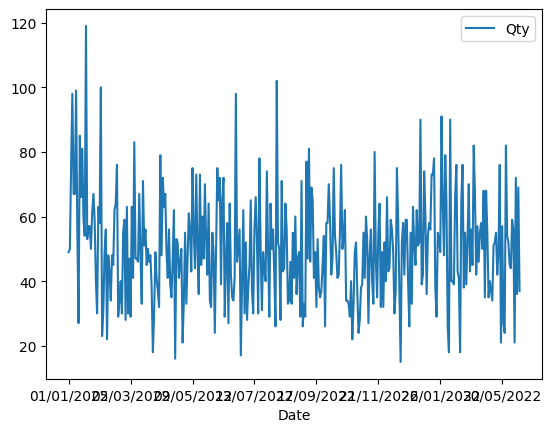

In [15]:
daily_qty.plot()

In [4]:
dataSize = daily_qty.Qty.values.shape[0]
dataMat = daily_qty['Qty'].values.reshape(dataSize,1)
dataMat.shape

(365, 1)

In [5]:
# Normalizing Data
scaler = MinMaxScaler(feature_range=(0,1))
scaledDataMat = scaler.fit_transform(dataMat)

In [6]:
# Splitting Data
train_split = .85
train_size = int(train_split * dataSize)
trainData = scaledDataMat[:train_size]
valData = scaledDataMat[train_size:]

print('Train data size: ', trainData.shape)
print('Val data size: ', valData.shape)

Train data size:  (310, 1)
Val data size:  (55, 1)


In [7]:
# Creating windowed dataset
def createDataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step):
		dataX.append(dataset[i:(i+time_step)])
		dataY.append(dataset[i + time_step])
	return np.array(dataX), np.array(dataY)

In [8]:
  n_past = 7
  X_train,y_train = createDataset(trainData, time_step=n_past)
  X_val,y_val = createDataset(valData, time_step=n_past)

  print(X_train.shape, y_train.shape)
  print(X_val.shape, y_val.shape)

(303, 7, 1) (303, 1)
(48, 7, 1) (48, 1)


# Building and Training Model

In [9]:
model = Sequential()

model.add(LSTM(128, activation='relu', input_shape=[n_past,1], return_sequences=True))
model.add(LSTM(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 128)            66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 132,609
Trainable params: 132,609
Non-trainable params: 0
_________________________________________________________________


In [10]:
adam = tf.keras.optimizers.Adam(learning_rate=1e-6)

model.compile(loss='mean_squared_error',optimizer=adam)

history = model.fit(X_train,y_train,
                    validation_data=(X_val,y_val),
                    epochs=300,
                    batch_size=3,
                    verbose=1)

Epoch 1/300
101/101 [==============================] - 10s 21ms/step - loss: 0.1351 - val_loss: 0.1402
Epoch 2/300
101/101 [==============================] - 2s 17ms/step - loss: 0.1340 - val_loss: 0.1391
Epoch 3/300
101/101 [==============================] - 2s 17ms/step - loss: 0.1329 - val_loss: 0.1379
Epoch 4/300
101/101 [==============================] - 3s 26ms/step - loss: 0.1318 - val_loss: 0.1368
Epoch 5/300
101/101 [==============================] - 2s 19ms/step - loss: 0.1307 - val_loss: 0.1356
Epoch 6/300
101/101 [==============================] - 2s 17ms/step - loss: 0.1296 - val_loss: 0.1345
Epoch 7/300
101/101 [==============================] - 2s 17ms/step - loss: 0.1285 - val_loss: 0.1334
Epoch 8/300
101/101 [==============================] - 2s 17ms/step - loss: 0.1274 - val_loss: 0.1322
Epoch 9/300
101/101 [==============================] - 2s 17ms/step - loss: 0.1264 - val_loss: 0.1311
Epoch 10/300
101/101 [==============================] - 2s 17ms/step - loss: 0.12

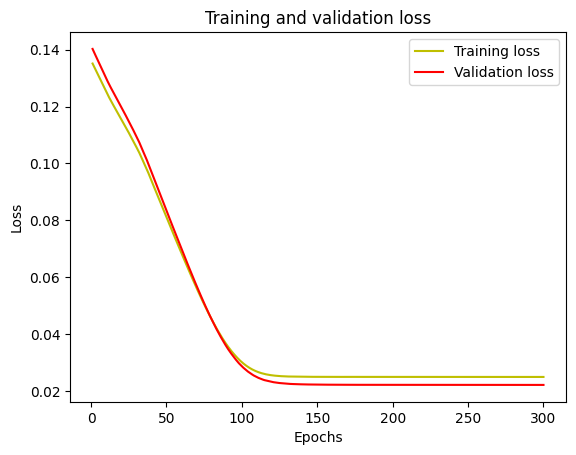

In [11]:
# Visualizing loss during training
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Performance Evaluation

In [16]:
# Inverting back to original scales
y_train_hat = scaler.inverse_transform(model.predict(X_train))
y_val_hat = scaler.inverse_transform(model.predict(X_val))

ytrain = scaler.inverse_transform(y_train)
yval = scaler.inverse_transform(y_val)

2/2 [==============================] - 0s 8ms/step


Text(0, 0.5, 'Mingguan')

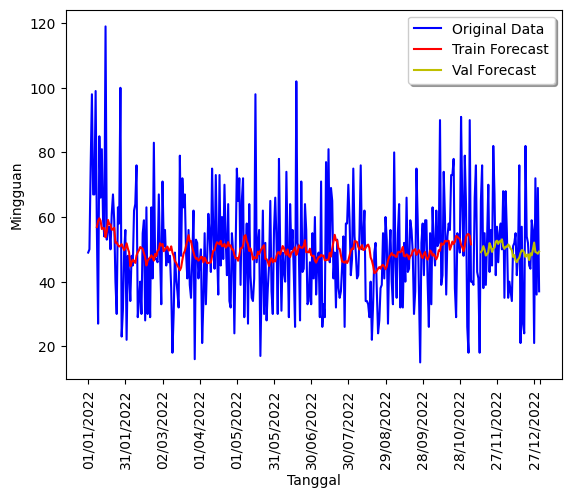

In [17]:
# Visualizing actual vs predicted value
train_shift = n_past
test_shift = train_shift + len(y_train_hat) + n_past

linspace = [0]
while linspace[-1] < 365-30:
    linspace.append(linspace[-1]+30)
linspace.append(365)

dates = df['Date'].drop_duplicates().tolist()

plt.plot(dates, daily_qty['Qty'], color='b', label="Original Data")
plt.plot(dates[train_shift: test_shift-n_past], y_train_hat, color='r', label="Train Forecast")
plt.plot(dates[test_shift:], y_val_hat, color='y', label="Val Forecast")
plt.legend(loc='best', shadow=True)

plt.xticks(linspace, rotation='vertical')
plt.xlabel('Tanggal')
plt.ylabel('Mingguan')

In [18]:
# Computing error metrics
mae = mean_absolute_error(yval, y_val_hat)
mae

12.555999279022217

# **Forecast 7 Hari Kedepan**


In [19]:
# Defining function to generate the multi-step forecasts
def multi_step_forecasts(n_past, n_future):

    x_past = X_val[- n_past - 1:, :, :][:1]  # last observed input sequence
    y_past = y_val[- n_past - 1]             # last observed target value
    y_future = []                        # predicted target values

    for i in range(n_past + n_future):

        # feed the last forecast back to the model as an input
        x_past = np.append(x_past[:, 1:, :], y_past.reshape(1, 1, 1), axis=1)

        # generate the next forecast
        y_past = model.predict(x_past)

        # save the forecast
        y_future.append(y_past.flatten()[0])

    # transform the forecasts back to the original scale
    y_future = scaler.inverse_transform(np.array(y_future).reshape(-1, 1)).flatten()

    return y_future

In [20]:
# Forecast the next 7 days
fc_ahead = multi_step_forecasts(n_past=0, n_future=7)

1/1 [==============================] - 0s 23ms/step


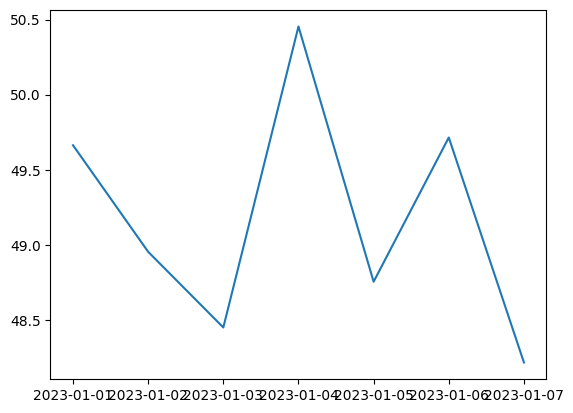

In [33]:
from datetime import datetime

datelist = pd.date_range(start='01/01/2023', periods=7, freq='D')
plt.plot(datelist,fc_ahead)

Ref: https://stackoverflow.com/questions/70420155/how-to-predict-actual-future-values-after-testing-the-trained-lstm-model/70421046#70421046